## Imports

In [1]:
from pycromanager import Core, Studio
import imagej
from skimage import io as skio
import pickle
import os.path as path
import os
import numpy as np
from tqdm.notebook import tqdm
import yaml
from smartpath_libraries.sp_stitcher import SPStitcher
from smartpath_libraries.sp_acquisition import SPAcquisition
import scyjava
from IPython.utils import io as ipio
scyjava.config.add_option('-Xmx16g') # Set the memory available to Java run-time

## Initialize ImageJ and Pycro-Manager

In [2]:
wdir = os.getcwd()
core = Core()
studio = Studio()
ij = imagej.init('sc.fiji:fiji:2.1.0', mode='headless') # Load ImageJ, https://github.com/imagej/pyimagej
print(f"ImageJ version: {ij.getVersion()}")
core.set_timeout_ms(20000)
print("Succeeded!")
os.chdir(wdir)

ImageJ version: 2.1.0/1.53c
Succeeded!


## Read configuration file

In [3]:
config = yaml.load(open("config.yaml", "r"), Loader=yaml.FullLoader)
config = {**config['user_config'], **config['model_config'], **config['hard_config']}
lsm_pixel_size_base = config['pixel-size-shg-base']
bf_4x_pixel_size_base = config['pixel-size-bf-4x']
bf_20x_pixel_size_base = config['pixel-size-bf-20x']
camera_resolution_base = config['camera-resolution']
config

{'exposure-level': 'high',
 'snr-level': 'low',
 'autofocus-speed': 3,
 'lsm-resolution': 256,
 'lsm-bin-factor': 15,
 'lsm-scan-rate': '250000.0000',
 'lsm-pc-power': 0.4,
 'lsm-pmt-gain': 0.4,
 'slide-box': [-100, 600, 25500.0, 17000.0],
 'lsm-enhancer': None,
 'bf-enhancer': None,
 'classifier': None,
 'adv-interval': 3,
 'average-factor': 50,
 'batch-size': 8,
 'blindspot-rate': 0.05,
 'cnn-base-channel': 8,
 'dataset': 'datasets/PA_2081b',
 'gan-lambda': 5,
 'gpu': True,
 'image-channel': 1,
 'image-extension': 'tif',
 'iter-per-epoch': 200,
 'iterations': 200000,
 'learning-rate': 0.0001,
 'load-weights': 'supervised2022-08-07_13-02-52',
 'loss-gain': 1000,
 'norm-range': [5420, 44017],
 'norm-range-target': [6265, 38567],
 'only-pixel-loss': False,
 'percep-lambda': 0.5,
 'resolution': 512,
 'test-interval': 5,
 'threads': 0,
 'up-scale-factor': 2,
 'pixel-size-bf-20x': 0.222,
 'pixel-size-bf-4x': 1.105,
 'pixel-size-shg-base': 0.509,
 'pixel-size-shg': 0.509,
 'camera-resolutio

## Initialize scanner and stitcher object

In [4]:
### User configuration block

save_path = 'data/acquisition'

acq_name = 'PA2081b_0903' # No Spaces in name! Use - or _ No `ome` in name!

# slide_box = [-1000, 2000, 26000, 24000]
slide_box = [3000, 8000, 11000, 20000]
brightfield_4x_background_fname = 'data/presets/BG_4x.tiff' # give a default 4x background image
brightfield_20x_background_fname = 'data/presets/BG_20x.tiff' # give a default 20x background image
qupath_fname = os.path.join('QuPath-0.3.2', 'QuPath-0.3.2.exe') # QuPath executable, os.sep does matter!!!
### 


sp_acq = SPAcquisition(
    config=config,
    mmcore=core, 
    mmstudio=studio,
    bf_4x_bg=skio.imread(brightfield_4x_background_fname), 
    bf_20x_bg=skio.imread(brightfield_20x_background_fname), 
    )

sp_sti = SPStitcher(
    config=config, 
    ij=ij,
    working_dir=save_path,
    qupath_dir=qupath_fname, 
    )

sp_acq.update_slide_box(slide_box)
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x

Load LSM presets.


### Optional brightfield run-time processor

In [15]:
### Rescale the image (optional)
from skimage.transform import rescale
downsampler = lambda x: rescale(x, 0.5, order=1, channel_axis=-1)
sp_acq.bf_process_fn = downsampler
# pixel size will change
sp_acq.config['pixel-size-bf-4x'] = bf_4x_pixel_size_base * 2
sp_acq.config['pixel-size-bf-4x'] = bf_4x_pixel_size_base * 2
sp_acq.config['camera-resolution'] = [int(camera_resolution_base[0]/2), int(camera_resolution_base[1]/2)]
sp_sti.config['pixel-size-bf-20x'] = bf_20x_pixel_size_base * 2
sp_sti.config['pixel-size-bf-20x'] = bf_20x_pixel_size_base * 2

## 4x acquisition

### Set objective and modality
This is necessary to resume an interupted session. The same 4x scan name must be used.

In [16]:
acq_name_4x = acq_name + '-4x-bf'
sp_acq.switch_objective(mag='4x')
sp_acq.switch_mod(mod='bf')

Imaging objective set as 4x
Imaging objective set as 4x
Imaging mode set as Brightfield


### Focus on the sample

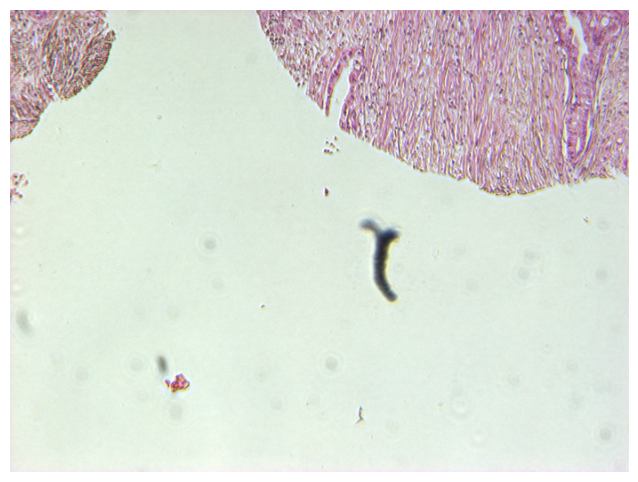

In [18]:
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [19]:
sp_acq.update_focus_presets(mag='4x', mod='bf') # update focus preset

### Change some settings (optional)

In [20]:
sp_acq.config['autofocus-speed'] = 4 # 1-6

### Perform the scan

In [21]:
### perform the scan
sp_acq.switch_objective(mag='4x')
sp_acq.switch_mod(mod='bf')
position_list_4x = sp_acq.generate_grid(mag='4x', overlap=50)
sp_acq.position_list_4x = position_list_4x
results_4x = sp_acq.whole_slide_bf_scan(
    save_path, 
    acq_name_4x, 
    position_list_4x.reshape(position_list_4x.shape[0]*position_list_4x.shape[1], -1), 
    mag='4x',
    focus_dive=True,
    estimate_background=False,
    )
### save background image and z positions, and position_list
results_4x['Position list'] = position_list_4x
sp_acq.z_list_4x = results_4x['Z positions']
with open(path.join(save_path, acq_name_4x+'.pkl'), 'wb') as f:
    pickle.dump(results_4x, f)

### perform the stitching
position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
with ipio.capture_output() as captured:
    sp_sti.stitch_bf(
        acq_name_4x,
        mag='4x',
        position_list=position_list,
        flip_y=True,
        correction=False, # this should be set `True` if the default background image was not given during the acquisition
        background_image=None # this should be given as `loaded_results_4x['Background image']` `correction` is `True`
        )
sp_sti.convert_slide(mag='4x')
### optional clean the intermediate stitching files
sp_sti.clean_folders(acq_name_4x)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [01:34<00:00,  1.72s/it]

 55/55 tiles done

Converting slide to ome.tif
[4,2.21]


## 20x acquisition

### Set objective and modality

In [22]:
sp_acq.switch_mod(mod='bf') 
sp_acq.switch_objective(mag='20x')

Imaging objective set as 4x
Imaging mode set as Brightfield
Imaging objective set as 20x


### Focus on the sample

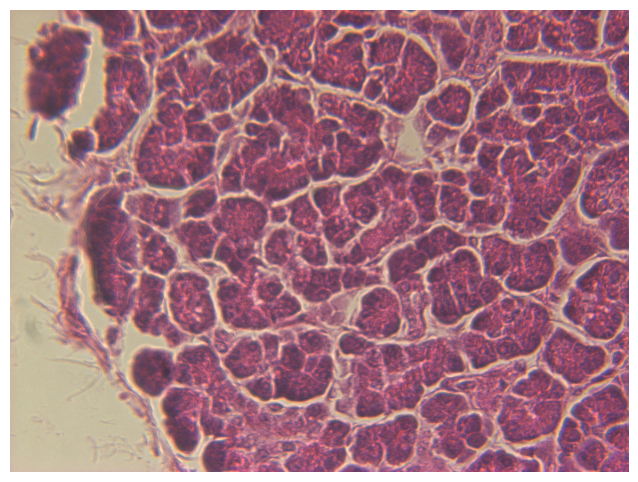

In [23]:
last_img = sp_acq.live(mod='bf', flip_channel=True)

In [24]:
sp_acq.update_focus_presets(mag='20x', mod='bf')

In [25]:
sp_acq.config["autofocus-speed"] = 4 

### Perform the scan

In [26]:
### load 4x results from disk
sp_acq.switch_mod(mod='bf') 
sp_acq.switch_objective(mag='20x')
with open(path.join(save_path, acq_name_4x+'.pkl'), 'rb') as f:
    loaded_results_4x = pickle.load(f)
sp_acq.position_list_4x = loaded_results_4x['Position list']
sp_acq.z_list_4x = loaded_results_4x['Z positions']
position_list_xyz = np.concatenate((   
    sp_acq.position_list_4x, 
    sp_acq.z_list_4x.reshape((sp_acq.position_list_4x.shape[0], sp_acq.position_list_4x.shape[1], 1))
    ), 2)
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
position_lists_20x, annotation_names = zip(*sorted(zip(position_lists_20x, annotation_names), key=lambda x: int(x[1].split('-')[-1])))
### perform the scan
sp_acq.position_list_20x = []
sp_acq.z_list_20x = []
for idx, (roi_pos, roi_name) in tqdm(enumerate(zip(position_lists_20x, annotation_names))):
    current_acq_name = acq_name + '-20x-' + annotation_names[idx]
    sampled_pos_xyz = sp_acq.resample_z_pos(mag='20x', xy_pos=roi_pos, xyz_pos_list_4x=position_list_xyz)
    results_20x = sp_acq.whole_slide_bf_scan(
        save_path, 
        current_acq_name, 
        sampled_pos_xyz, 
        mag='20x',
        focus_dive=True,
        estimate_background=False,
        )
    sp_acq.position_list_20x.append(sampled_pos_xyz)
    sp_acq.z_list_20x.append(results_20x['Z positions'])
    sp_acq.config['Z-stage-20x'] = np.mean(np.hstack(sp_acq.z_list_20x))
    ### save background image and z positions, and position_list
    position_list=sp_acq.position_list_4x.reshape(sp_acq.position_list_4x.shape[0]*sp_acq.position_list_4x.shape[1], -1)
    with ipio.capture_output() as captured:
        sp_sti.stitch_bf(
            current_acq_name,
            mag='20x',
            position_list=sampled_pos_xyz,
            flip_y=True,
            correction=False, 
            background_image=None 
            )
    sp_sti.convert_slide(mag='20x')
    sp_sti.clean_folders(current_acq_name) # optional
np.save(os.path.join(save_path, acq_name +'-20x'+'-z_pos.npy'), sp_acq.z_list_20x, allow_pickle=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [01:12<00:00,  2.18s/it]

 33/33 tiles done

Converting slide to ome.tif


## Perform SHG scan

### Change SHG scan settings

In [27]:
sp_acq.config["lsm-scan-rate"] = '500000.0000' # slow: '100000.0000'; fast: '500000.0000'
sp_acq.config["lsm-pc-power"] = 0.5 # max 0.7
sp_acq.config["lsm-pmt-gain"] = 0.7 # max 0.8 
sp_acq.config["lsm-resolution"] = 256 # slow: 512; fast: 256
sp_acq.config_preset(sp_acq.config)
sp_sti.config = sp_acq.config
sample_depth = 21 
z_step = 7 
sp_acq.dump_configuration(acq_name)
sp_acq.core.set_property('OSc-LSM', 'PXI2Slot2-GalvoOffsetX (degree)', 0.45) # Adjustment to match FOV of different settings

### Set objective and modality
It is necessary to set the modality to update the scanning parameters

In [28]:
sp_acq.switch_objective(mag='20x')
sp_acq.switch_mod(mod='shg')

Imaging objective set as 20x
Imaging mode set as SHG


### Enable a run-time processer for the LSM acquisition (optional)

In [29]:
### Median filter for example
from skimage.filters import median
from skimage.morphology import diamond
func = lambda image: median(image, footprint=diamond(1))
# func = lambda image: image # just pass the image witout processing
sp_acq.define_lsm_processor(func)

In [10]:
### A wavelet denoiser
from skimage.restoration import denoise_wavelet
def func(image):
    denoised = denoise_wavelet(image, rescale_sigma=True)
    return denoised
sp_acq.define_lsm_processor(func)

In [11]:
### A total varition-based denoiser
from skimage.restoration import denoise_tv_chambolle
def func(image):
    denoised = denoise_tv_chambolle(image, weight=0.005)
    return denoised
sp_acq.define_lsm_processor(func)

In [ ]:
### Deep neural networks
from smartpath_libraries.enhancer import Enhancer
import torch
model_config = config
enhancer = Enhancer(model_config, scale_factor=model_config['up-scale-factor'], perceptual_loss=True, adversarial_loss=True)
enhancer.backbone.load_state_dict(torch.load(os.path.join('weights', 'enhancer.pth')))
sp_acq.define_lsm_processor(network=enhancer)

In [9]:
# Or just pass the image witout processing
func = lambda image: image 
sp_acq.define_lsm_processor(func)

### Perform the scan

In [ ]:
position_lists_mp, annotation_mp = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='mp')
position_lists_mp, annotation_mp = zip(*sorted(zip(position_lists_mp, annotation_mp), key=lambda x: int(x[1].split('-')[-1])))
position_lists_20x, annotation_names = sp_acq.annotations_positionlist(image_name=acq_name_4x, out_mag='20x')
position_lists_20x, annotation_names = zip(*sorted(zip(position_lists_20x, annotation_names), key=lambda x: int(x[1].split('-')[-1])))
return_20x_list = np.load(os.path.join(save_path, acq_name+'-20x'+'-z_pos.npy'), allow_pickle=True).tolist()
return_20x_list = np.vstack(return_20x_list)
map_xyz_20x = np.concatenate((np.vstack(position_lists_20x), return_20x_list.reshape((return_20x_list.shape[0], 1))), 1)
sp_acq.lsm_reset_PMT()
for idx, (roi_pos, roi_name) in enumerate(zip(position_lists_mp, annotation_mp)):
    if idx < 0: continue
    sp_acq.switch_objective(mag='20x')
    sp_acq.switch_mod(mod='shg')
    current_acq_name = acq_name + '-lsm-slow-' + roi_name
    # roi_pos[:, 0] = roi_pos[:, 0] #- 2907
    # roi_pos[:, 1] = roi_pos[:, 1] #+ 3183 
    sampled_pos_xyz_mp = sp_acq.resample_z_pos(mag='mp', xy_pos=roi_pos, xyz_pos_list_20x=map_xyz_20x)
    sp_acq.whole_slide_lsm_scan(
        save_path, 
        acq_name=current_acq_name, 
        position_list=sampled_pos_xyz_mp, 
        z_stack=True, 
        sample_depth=sample_depth, 
        z_step=z_step
        )
    num_channel = int(sample_depth/z_step)+1
    with ipio.capture_output() as captured:
        sp_sti.stitch_lsm(
            save_path, 
            current_acq_name, 
            n_stack=3, 
            position_list=sampled_pos_xyz_mp, 
            flip_y=False, 
            rotate=270
            )
        sp_sti.convert_slide(mag='mp')
        # sp_sti.clean_folders(current_acq_name)

In [6]:
user_config = {
    
    ### User configuration ###
    
    # Quick configuration group for LSM
    "exposure-level" : 'high',
    # 'low'     -> scan rate: '500000.0000', pockel cell gain: 0.30, PMT gain: 0.40
    # 'mid'     -> scan rate: '400000.0000', pockel cell gain: 0.45, PMT gain: 0.45
    # 'high'    -> scan rate: '250000.0000', pockel cell gain: 0.60, PMT gain: 0.50
    # 'extreme' -> scan rate: '200000.0000', pockel cell gain: 0.75, PMT gain: 0.55
    
    "snr-level" : 'low',
    # Estimiated correction according to sample SNR level. Available value: 'low', 'mid', 'high', by default raw data is collected
    
    "autofocus-speed" : 3,
    # Speed of software autofocus, integer: 1~5. Bigger value leads to faster brightfield scan but potentially lower autofocus performance
       
    "lsm-resolution" : 256, 
    # LSM scan resolution, available resolution: 256, 512, 1024
    
    "lsm-bin-factor" : 15,
    # LSM scan pixel average factor, positive integer
    
    "lsm-scan-rate" : '250000.0000', 
    # LSM scan rate, available value (string): '125000.0000', '200000.0000', '250000.0000','400000.0000', '500000.0000', '625000.0000', '1000000.0000'
    
    "lsm-pc-power" : 0.4, 
    # LSM pockel cell gain, float point value: 0.0 ~ 1.0
    
    "lsm-pmt-gain" : 0.4,
    # LSM PMT gain, float point value: 0.0 ~ 1.0
    
    "slide-box" : (-100, 600, 25500.0, 17000.0), 
    # Pre-define scan area (read out values from the stage): (start x stage position, start y stage position, end x stage position, end y stage position)
    
    "lsm-enhancer" : None,
    
    "bf-enhancer" : None,
    
    "classifier" : None,
    # Automatic target detection model, available value (string or None): 'MIL', 'Supervised', None 
    
}

model_config = {
    
    "gpu" : False,
    # Is GPU available? Available value (boolean): True, False
    
    "batch-size" : 32,
    # Is GPU available? Available value (boolean): True, False 
    
    ### configure enhancer ###
    
    "image-channel" : 1,
    
    "dropout-rate" : 0.1, 
    
    "cnn-base-channel" : 4,
    
    "normalization" : None,
    # CNN normalization layere type
    
    "norm-range" : (13251, 63085),
    # Image normalization range, determined via *_dataset_preprocessing.ipynb in lsm-run-time-enhancement repo
         
    
    "dimension" : '2D',
    
    ### configure classifier
    
    "classifier-backbone" : 'ResNet18',
    # Backbone for CNN model, available value (string): 'ResNet18', 'ResNet34' 
    
    "classifier-num-class" : 2,
    # Number of class for the detector, non-zero integer
    
    "mil-classifier-thresh" : 2,
    # Threshold for MIL classifier. Obtained from training.
    
    "slide-type" : 'TMA',
    # Type of image the inference is applied, available value (string): "TMA", "slide"      

}

### right general save range check function
hard_config = {
    ### Hard configuration, 
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg-base" : 0.509, # 0.509 micron/pixel at 256
    "pixel-size-shg" : 0.509,
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),
    "slide-size" : (40000.0, 20000.0), # (width, height) (70000, -20000)
#     "Z-stage-20x" : -6930, # -6930 + 290 / 10500
    "Z-stage-20x" : -6980, # -6930 + 290 / 10500
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15800, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "Z-bf-offset" : -10500,
    "Z-laser-offset" : 290,
    "hard-limit-z" : (-8500.0, 17000.0),
    "hard-limit-x" : (-5000.0, 40000.0),
    "hard-limit-y" : (-4200, 25000.0), #(-2200, 19000.0)
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-600, 10), # 4x + this value to 20x // (-590, 74)
    "shg-offset" : (-580, -280), # 4x + this value to shg // (-580, -172)
    "led-4x" : 4,
    "led-20x" : 5,
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}